# 'What's on the menu?' analysis

For this first analysis, we chose [on Kaggle](https://www.kaggle.com/nypl/whats-on-the-menu
) the dataset "What's on the menu?" from NYLP (New York Public Library). They transcribed approximately 45,000 menus from historical restaurants, dish by dish, dating from the 1840s to the present.

The dataset is composed by 4 tables:
- `menu.csv`: The core element of the dataset. Each Menu has a unique identifier and associated data, including data on the venue and/or event that the menu was created for; the location that the menu was used; the currency in use on the menu; and various other fields. Each menu is associated with some number of MenuPage values.
- `menupage.csv`: Each MenuPage refers to the Menu it comes from, via the menu_id variable (corresponding to Menu:id). Each MenuPage also has a unique identifier of its own. Associated MenuPage data includes the page number of this MenuPage, an identifier for the scanned image of the page, and the dimensions of the page. Each MenuPage is associated with some number of MenuItem values.
- `menuitem.csv`: Each MenuItem refers to both the MenuPage it is found on -- via the menu_page_id variable -- and the Dish that it represents -- via the dish_id variable. Each MenuItem also has a unique identifier of its own. Other associated data includes the price of the item and the dates when the item was created or modified in the database.
- `dish.csv`: A Dish is a broad category that covers some number of MenuItems. Each dish has a unique id, to which it is referred by its affiliated MenuItems. Each dish also has a name, a description, a number of menus it appears on, and both date and price ranges.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

## Dish analysis

First let's analyse the `dish.csv` dataset. According to [documentation](https://www.kaggle.com/prashant111/discover-the-menu), the dataset includes 45,000 menus from the 1840s to the present.
Although the Menu table is the core element of the dataset, we will examine the Dish table, because according to Kaggle information, it has more numeric fields and also because it has more possibilities to explore.

In [2]:
dish = pd.read_csv('dish.csv')

In [3]:
dish.head(10)

,id,name,description,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
0,1,Consomme printaniere royal,NaN,8,8,1897,1927,0.20,0.4
1,2,Chicken gumbo,NaN,111,117,1895,1960,0.10,0.8
2,3,Tomato aux croutons,NaN,14,14,1893,1917,0.25,0.4
3,4,Onion au gratin,NaN,41,41,1900,1971,0.25,1.0
4,5,St. Emilion,NaN,66,68,1881,1981,0.00,18.0
5,7,Radishes,NaN,3263,3347,1854,2928,0.00,25.0
6,8,Chicken soup with rice,NaN,48,49,1897,1961,0.10,0.6
7,9,Clam broth (cup),NaN,14,16,1899,1962,0.15,0.4
8,10,"Cream of new asparagus, croutons",NaN,2,2,1900,1900,0.00,0.0
9,11,Clear green turtle,NaN,156,156,1893,1937,0.25,60.0


In [4]:
dish.describe()

,id,description,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
count,426993.000000,0.0,426993.000000,426993.000000,426993.000000,426993.000000,397892.000000,397892.000000
mean,266588.651004,NaN,3.044026,3.124248,1661.403852,1665.157157,0.956543,1.589384
std,151628.639740,NaN,27.705055,29.846205,666.401166,667.074868,6.684786,12.639699
min,1.000000,NaN,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000
25%,133490.000000,NaN,1.000000,1.000000,1900.000000,1900.000000,0.000000,0.000000
50%,271669.000000,NaN,1.000000,1.000000,1914.000000,1917.000000,0.000000,0.000000
75%,400123.000000,NaN,1.000000,1.000000,1949.000000,1955.000000,0.400000,0.550000
max,519521.000000,NaN,7748.000000,8496.000000,2928.000000,2928.000000,1035.000000,3050.000000


From the brief description above, we see that there's something weird with the `description` column. Let's check the completeness (not null values) for each column. This can be seen on the "count" row above, but in absolute numbers. We'll see it in terms of a percentage of not null / all rows.

In [5]:
dish.id.notna().sum()/len(dish)

for col in dish.columns:
    comp = dish[col].notna().sum()/len(dish)
    txt = '{col:<14} | {b:.1%} complete'.format(col=col, b = comp)
    print(txt)

id             | 100.0% complete
name           | 100.0% complete
description    | 0.0% complete
menus_appeared | 100.0% complete
times_appeared | 100.0% complete
first_appeared | 100.0% complete
last_appeared  | 100.0% complete
lowest_price   | 93.2% complete
highest_price  | 93.2% complete


So, we have that the `description` column is useless, since it has 100% of null values. Let's drop this column from now on.

In [6]:
dish.drop(['description'], axis=1, inplace=True)

An interesting aspect of this dataset is that it has just one non-numerical column, and 6 numerical ones.

But first let's take a closer look at the description table above. There are some weird things there.

First, looking at the `first_appeared` and `last_appeared` fields, we see that the minimum value is 0 and the maximum is 2938. As per documentation, we know that these are the years the dish appeared first and last, so it's very weird that they are 1, 0, or greater than 2020.

Let's see how many abnormalities we have like this on these 2 fields.

In [7]:
len(dish[(dish.first_appeared <= 1) & (dish.last_appeared <= 1)])/len(dish)

0.13796713295065727

In [8]:
len(dish[(dish.last_appeared >= 2020) & (dish.last_appeared >= 2020)])/len(dish)

0.00041921061937783525

So, almost 14% of our data has years of first and last appearances <= 1. I don't believe we have enough information for now to complete/replace this data, so we will create a new dataframe for now without these dishes. In the future we will deep dive on this.

Another weird thing is on the field `times_appeared`, where we see that the minimum value is -6. Since it is impossible to a dish to appear NEGATIVE times on a menu, let's examine this data.

In [9]:
len(dish[dish.times_appeared <= 0])/len(dish)

0.027934884178429154

In [10]:
dish[dish.times_appeared <= 0].head(10)

,id,name,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
676,825,"Rice, Semolina",1,0,1900,1900,0.00,0.00
1229,1457,For,1,0,1901,1901,0.00,0.00
1232,1460,Exclusively,1,0,1901,1901,0.00,0.00
1234,1462,address.,1,0,1901,1901,0.00,0.00
1236,1464,This,1,0,1901,1901,0.00,0.00
1237,1465,side,1,0,1901,1901,0.00,0.00
2356,2799,""" "" half pint",1,0,1901,1901,0.10,0.10
2545,3031,""" saute with mushrooms",1,0,1900,1900,0.00,0.00
2546,3032,""" a la Lyonnaise",1,0,1900,1900,0.35,0.35
2547,3033,""" en brochette",1,0,1900,1900,0.50,0.50


In [11]:
dish_clean = dish[(dish.first_appeared > 1) & (dish.last_appeared > 1) &
            (dish.last_appeared <= 2020) & (dish.times_appeared >= 0)]
dish_clean.describe()

,id,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
count,367713.000000,367713.000000,367713.000000,367713.000000,367713.000000,339096.000000,339096.000000
mean,257743.229513,3.175863,3.263273,1928.217643,1931.202751,0.890988,1.607620
std,149120.555706,23.586446,25.320435,29.482006,29.403823,5.757183,12.843238
min,1.000000,0.000000,0.000000,1851.000000,1851.000000,0.000000,0.000000
25%,115500.000000,1.000000,1.000000,1901.000000,1906.000000,0.000000,0.000000
50%,270210.000000,1.000000,1.000000,1917.000000,1919.000000,0.000000,0.000000
75%,385480.000000,2.000000,2.000000,1955.000000,1958.000000,0.500000,0.650000
max,513510.000000,4323.000000,4778.000000,2012.000000,2012.000000,800.000000,3050.000000


From this brief descriptive analytics above, we see that even cleaning our data, some fields are still not widely distributed: when we see the quantiles for menus_appeared, times_appeared, lowest_price and highest_price, we have that there's a HUGE gap between the upper quartiles and the maximum values.

Let's see the distribution of these fields plotting histograms. We'll use log scales here.

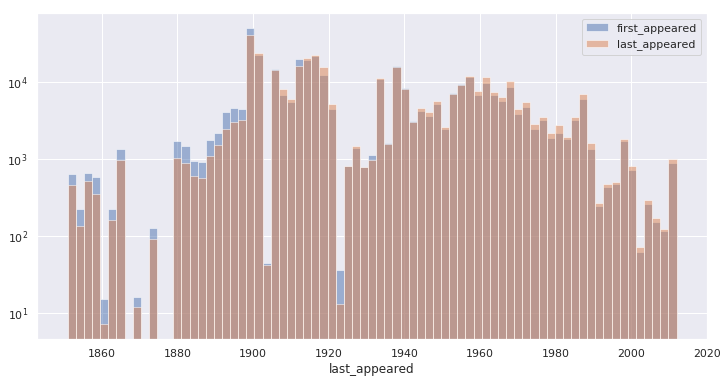

In [17]:
sns.set()
plt.subplots(figsize=(12, 6))

ax = sns.distplot(dish_clean.first_appeared, 75, label='first_appeared', hist_kws={"alpha": 0.5}, kde=False)
ao = sns.distplot(dish_clean.last_appeared, 75, label='last_appeared', hist_kws={"alpha": 0.5}, kde=False)

ax.legend(loc='upper right')
ax.set_yscale('log')
plt.show()

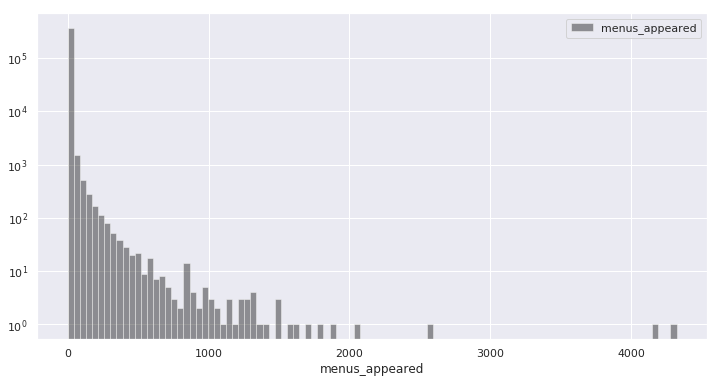

In [20]:
plt.subplots(figsize=(12, 6))

ax = sns.distplot(dish_clean.menus_appeared, 100, label='menus_appeared', kde=False, color='#000000')
ax.legend(loc='upper right')
ax.set_yscale('log')
plt.show()

/Users/fernandagomes/dev/mentoria/env_mentoria/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/fernandagomes/dev/mentoria/env_mentoria/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


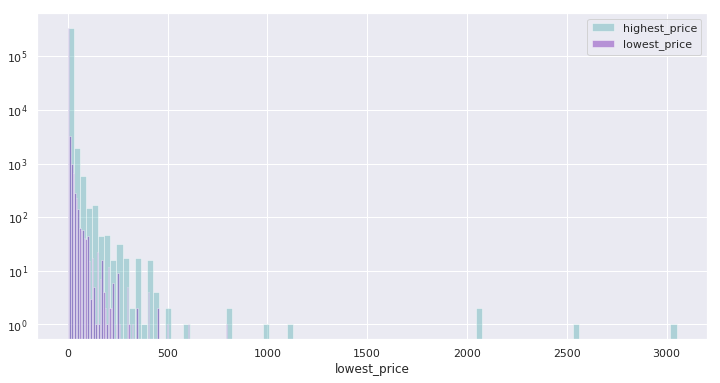

In [14]:
plt.subplots(figsize=(12, 6))

ao = sns.distplot(dish_clean.highest_price, 100, label='highest_price', kde=False, color='#52acb0')
ax = sns.distplot(dish_clean.lowest_price, 100, label='lowest_price', kde=False, color='#6a0dad')
ax.legend(loc='upper right')
ax.set_yscale('log')
plt.show()

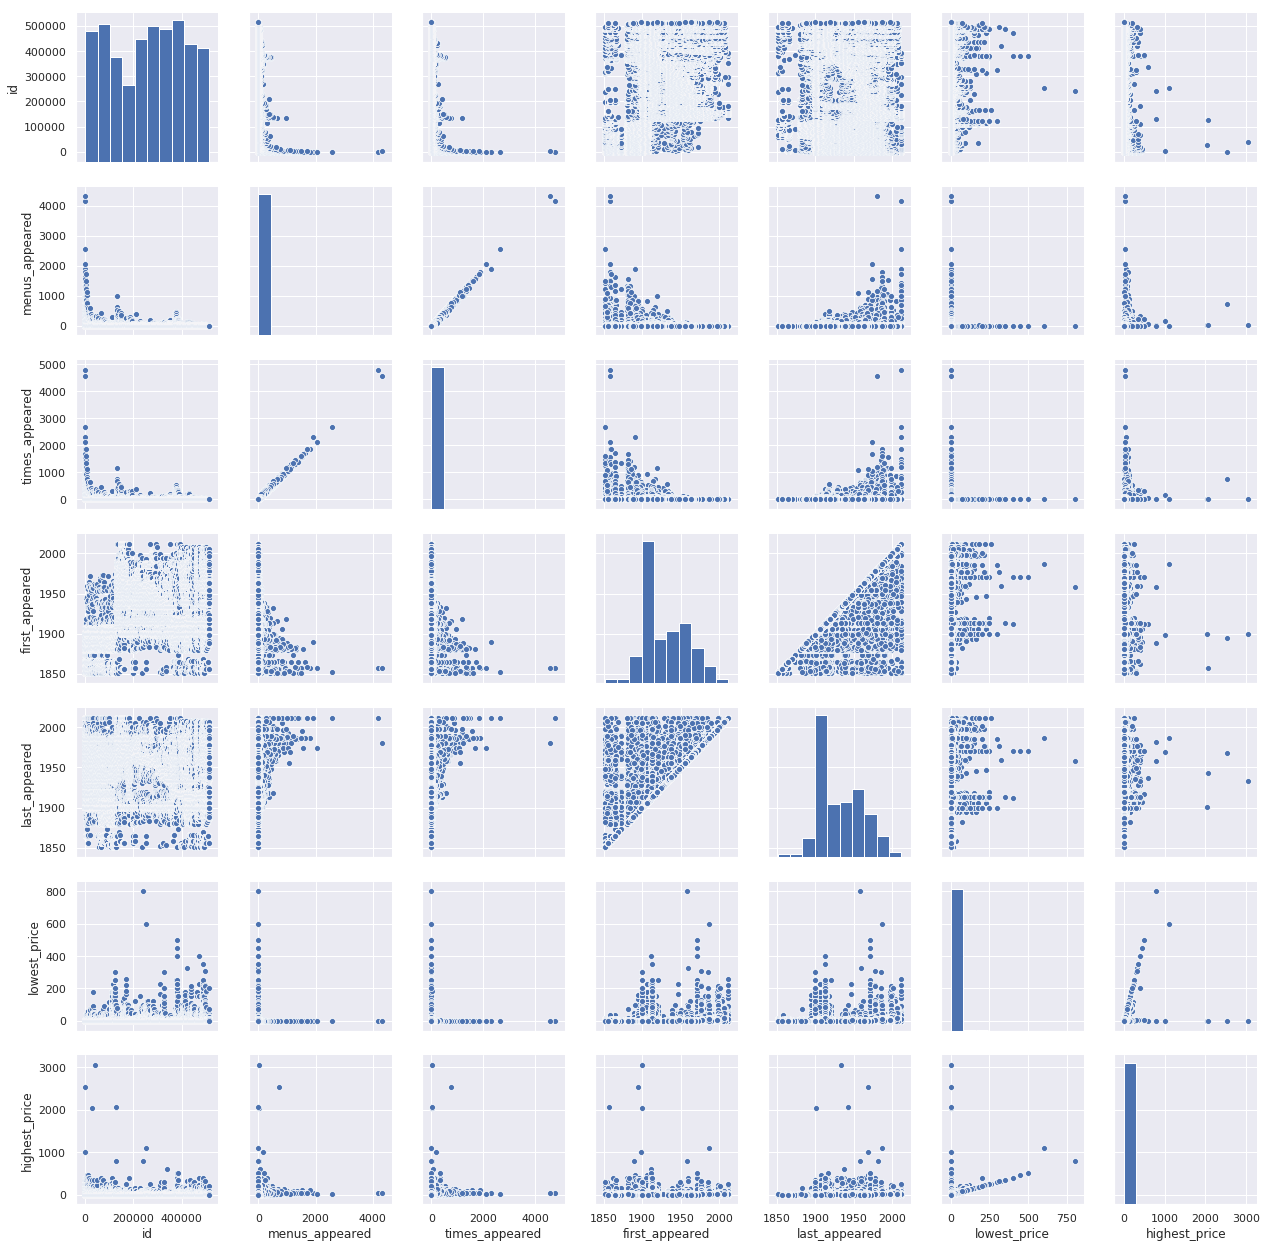

In [15]:
sns.pairplot(dish_clean)

# NOTES

I thought this dataset would be reacher and more evenly distributed, but I don't have a sense we can do many interesting things on this.